### - 참고 사이트 : https://wikidocs.net/102705

In [1]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# nltk.download('stopwords')

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/data.csv", filename="data.csv")
df = pd.read_csv("data.csv")
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 2382


In [4]:
# 유니코드...
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# 소문자로 변경
def make_lower_case(text):
    return text.lower()

# you, your 등 자주 쓰이는 단어 제거
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# html 제거 < or > . 등등
def remove_html(text):
    cleanr = re.compile('<.*?>')
    return re.sub(cleanr,'', text)

# 정규표현식 영어에 해당하는 단어들만 추출
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [5]:
df['cleaned'] = df['Desc'].apply(_removeNonAscii)
df['cleaned'] = df['cleaned'].apply(make_lower_case)
df['cleaned'] = df['cleaned'].apply(remove_stop_words)
df['cleaned'] = df['cleaned'].apply(remove_html)
df['cleaned'] = df['cleaned'].apply(remove_punctuation)

In [6]:
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 2381


In [7]:
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

### 사전 훈련된 임베딩 불러오기
[https://code.google.com/archive/p/word2vec/] 에서 "GoogleNews-vectors-negative300.bin.gz." 다운로드

In [8]:
word2vec_model = Word2Vec(vector_size = 300, window=5, min_count = 2, workers = -1)
word2vec_model.build_vocab(corpus)
word2vec_model.wv.vectors_lockf = np.ones(len(word2vec_model.wv), dtype = np.float32)
word2vec_model.wv.intersect_word2vec_format('GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)
word2vec_model.train(corpus, total_examples = word2vec_model.corpus_count, epochs = 15)

(0, 0)

### 임베딩 벡터 시각화 하기

In [9]:
word_to_vectors = [word2vec_model.wv[s] for s in word2vec_model.wv.key_to_index.keys()]
word_to_vectors = np.array(word_to_vectors)

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_to_vectors)

In [11]:
word_to_vectors.shape

(15641, 300)

In [12]:
head_n = 50

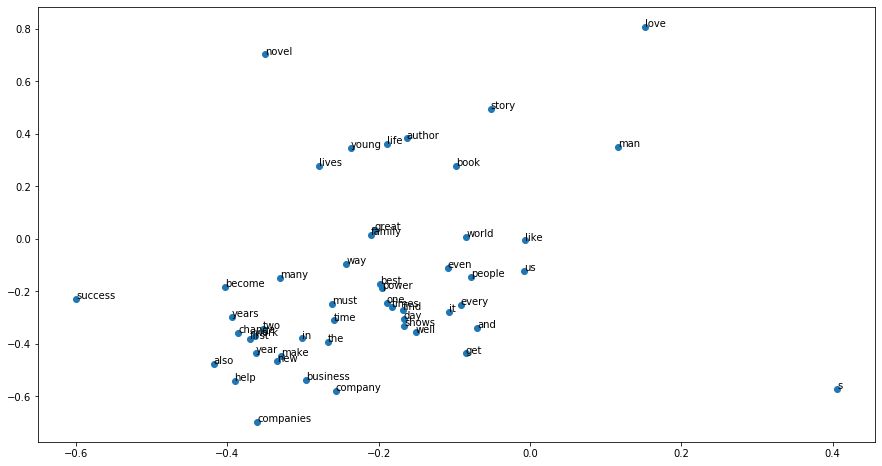

In [13]:
plt.figure(figsize = (15,8))
plt.plot(pca_result[:head_n,0],pca_result[:head_n,1], linestyle = '', marker = 'o')
for idx in range(head_n):
    plt.text(x = pca_result[idx,0],y = pca_result[idx,1],s = list(word2vec_model.wv.key_to_index.keys())[idx])

### 단어 벡터의 평균 구하기
- 1) 각 책 별로, 책에 대한 설명을 단어화 시킨 후 각 단어별 Word2Vec으로 변환
- 2) 하나의 책에 존재하는 단어들의 Word2Vec을 모두 더한 후 나누어서 책 별로 Vec 생성

In [31]:
def get_document_vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.key_to_index.keys():
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model.wv[word]
                else:
                    doc2vec = doc2vec + word2vec_model.wv[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [32]:
document_embedding_list = get_document_vectors(df['cleaned'])
print('문서 벡터의 수 :',len(document_embedding_list))

문서 벡터의 수 : 2381


### 추천시스템 구현하기

In [35]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (2381, 2381)


In [76]:
recommandation_n = 5
print('추천 책 개수 :',recommandation_n)

추천 책 개수 : 5


In [77]:
Title = 'The Da Vinci Code'
print('좋아하는 책 제목 :',Title)

좋아하는 책 제목 : The Da Vinci Code


In [78]:
books = df[['title', 'image_link']]
idx = np.argwhere((books['title'] == Title).values)[0][0]
rec_idx = np.argsort(cosine_similarities[:,idx])[::-1][1:recommandation_n+1]

In [82]:
for x,y in enumerate(books.iloc[rec_idx,:]['title']) :
    print(f'추천 순위 {str(x+1).zfill(2)} / Title : {y}')

추천 순위 01 / Title : The Lost Symbol
추천 순위 02 / Title : Origin
추천 순위 03 / Title : Jonathan Strange & Mr Norrell
추천 순위 04 / Title : Angels & Demons
추천 순위 05 / Title : The Miniaturist
